## Test the repo output

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import flow_vis

In [1]:
# # plt.imshow()
# !pip install flow_vis

In [3]:
import numpy as np
flow_file = '/home/yoyee/Documents/deep_keyframe/pytorch-pwc/flow.out.npy'
flow = np.load(flow_file)

In [4]:

flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=False)

In [5]:
flow_color.shape

(436, 1024, 3)

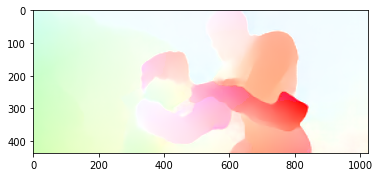

In [6]:

plt.imshow(flow_color)
plt.show()

## Test pwcNet

In [1]:
import numpy as np
from pwcNet import estimate
import torch

In [3]:
dummy_im = np.ones((120,160,3))
tenFirst = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
tenSecond = torch.FloatTensor(dummy_im[:, :, ::-1].transpose(2, 0, 1).astype(np.float32))
flow = estimate(tenFirst, tenSecond)

In [9]:
flow.shape
flow = flow.numpy().transpose([1,2,0])

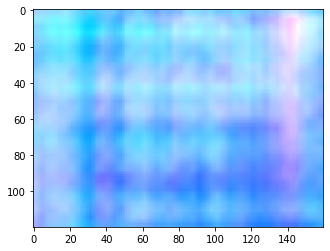

In [10]:
flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=False)
plt.imshow(flow_color)
plt.show()